# Librerias

In [113]:
using Pkg
Pkg.add("Plots")
Pkg.add("AbstractAlgebra")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


In [114]:
using Plots
using AbstractAlgebra

# Algoritmo XL

In [ ]:
function generate_random_system(F::Field, n::Int, m::Int; terms_per_eq::Int = 10)
    """
    Genera un sistema aleatorio de m ecuaciones cuadráticas en n variables sobre un cuerpo finito F.

    INPUT:
        - F: Cuerpo finito 
        - n: Número  de variables
        - m: Número de ecuaciones
        - terms_per_qe: Número máximo de terminos en cada ecuación

    OUTPUT:
        - Retorna un vector que contiene m polinomios cuadráticos generados 
          aleatoriamente con coeficientes en `F`.

    """
    R, vars = polynomial_ring(F, ["x$i" for i in 1:n])
    
    monoms_deg_1 = vars
    monoms_deg_2 = []

    # Crear monomios cuadráticos xi*xj con i ≤ j
    for i in 1:n
        for j in i:n
            push!(monoms_deg_2, vars[i] * vars[j])
        end
    end

    monoms_all = vcat(monoms_deg_1, monoms_deg_2)

    equations = AbstractAlgebra.Generic.MPoly{eltype(F)}[]
    for _ in 1:m
        selected = rand(monoms_all, min(terms_per_eq, length(monoms_all)))
        coeffs = [F(rand(0:characteristic(F)-1)) for _ in selected]
        poly = sum(coeffs[i] * selected[i] for i in 1:length(selected))

        # Agregar término constante aleatorio
        const_term = F(rand(0:characteristic(F)-1))
        poly += const_term

        push!(equations, poly)
    end

    return equations
end


function generate_monomials(vars::Vector{Any}, max_degree::Int)
    """
    Genera todos los monomios posibles en las variables 'vars' de grado menor o igual a 'max_degree'

    INPUT:
        - vars: Vectors con las variables del anillo de polinomios
        - max_dregree: Grado máximo para los monomios

    OUTPUT:
        - Retirna una lista con monommios de grado menor o igual a 'max_degree'    
    """
    
    n = length(vars)
    monomials = []

    exponents = Iterators.product((0:max_degree for _ in 1:n)...)
    for e in exponents
        if sum(e) <= max_degree
            push!(monomials, prod(vars[i]^e[i] for i in 1:n))
        end
    end
    return monomials
end

function xl_algorithm(F::Field, equations::Vector{MPoly}, max_degree::Int)
    """
    Implementación básica del algoritmo XL ("eXtended Linearization") sobre un sistema de ecuaciones cuadráticas

    INPUT:
        - F: Cuerpo finito
        - equations: Sistema de ecuaciones polinómicas cuadráticas
        - max_dregree: Grado máximo para los monomios

    OUTPUT:
        - Retorna un diccionario con relaciones entre monomios si el sistema extendido tiene soluciones
          `nothing` si no se encuentra ninguna.
    """

    R = parent(equations[1])
    vars = gens(R)
    n = length(vars)

    # Generar monomios de extension
    monomials_up_to_D = generate_monomials(vars, max_degree-2)

    # Extender el sistema
    extended_system = []
    for eq in equations
        for monom in monomials_up_to_D
            push!(extended_system, eq * monom)   # polynomial * ext_mon
        end
    end

    # Todos los monomios en el sistema extendido
    all_terms = generate_monomials(vars, max_degree)
    

    # Construir la matriz de coeficientes asociada al sistema extendido
    mem = @allocated begin
        M = zero_matrix(F, length(extended_system), length(all_terms))
        for (i, eq) in enumerate(extended_system)
            coeff_dict = Dict(zip(monomials(eq), coefficients(eq)))
            for (j, term) in enumerate(all_terms)
                M[i, j] = get(coeff_dict, term, zero(F))
            end
        end
        
    end

    # Calcular el espacio nulo de M para hallar las soluciones del sistema
    # Nota: Las soluciones estan dadas en terminos de relaciones entre polinomios, 
    #       no necesariamente en terminos de valores exactos para las variables  

    rank, N = nullspace(M)
    
    if rank == ncols(M) 
        return nothing, mem
    else
        solution_vector = N[:, 1]
        solution_dict = Dict(all_terms[i] => solution_vector[i] for i in 1:length(all_terms))
        return solution_dict, mem
    end

end

xl_algorithm (generic function with 1 method)

### Ejemplo

hdhwd

In [110]:
F = GF(2)
R, (x1, x2) = polynomial_ring(F, ["x1", "x2"])

f_1 = (x1 * x2) + x1 + 1
f_2 = x1 + x2

equations = [f_1, f_2]

solution, mem = xl_algorithm(F, equations, 3)

if solution === nothing
    println("No se encontró solución")
else
    println("Solución: ")
    for (term, coeff) in solution
        println("$term = $coeff")
    end
end

Solución: 
x2 = 0
1 = 0
x2^3 = 0
x1^2*x2 = 0
x1*x2^2 = 0
x1^2 = 0
x1^3 = 1
x1*x2 = 0
x2^2 = 0
x1 = 0


# Experimentos

In [124]:
D = 5             # Grado de extensión
F = GF(2)

mem_list = []
interval = 4:1:15

for i in interval
    n = i
    m = Int(floor(n/2))

    equations = generate_random_system(F, n, m)
    
    solution, mem = xl_algorithm(F, equations, 3)
    push!(mem_list, mem)

    println("Sistema de ecuaciones $(n) x $(m) requiere: $(mem) bytes")
end


Sistema de ecuaciones 4 x 2 requiere: 43240 bytes
Sistema de ecuaciones 5 x 2 requiere: 69112 bytes
Sistema de ecuaciones 6 x 3 requiere: 175032 bytes
Sistema de ecuaciones 7 x 3 requiere: 265048 bytes
Sistema de ecuaciones 8 x 4 requiere: 533752 bytes
Sistema de ecuaciones 9 x 4 requiere: 766328 bytes
Sistema de ecuaciones 10 x 5 requiere: 1349368 bytes
Sistema de ecuaciones 11 x 5 requiere: 1832536 bytes
Sistema de ecuaciones 12 x 6 requiere: 2943112 bytes
Sistema de ecuaciones 13 x 6 requiere: 3909112 bytes
Sistema de ecuaciones 14 x 7 requiere: 5936248 bytes
Sistema de ecuaciones 15 x 7 requiere: 7489112 bytes


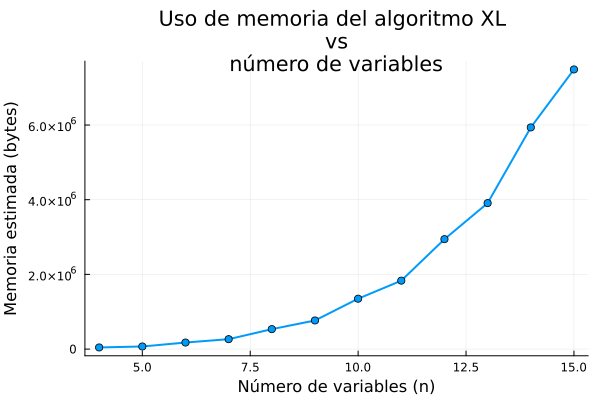

In [125]:
# Generar gráfica
plot(interval, mem_list,
    xlabel="Número de variables (n)",
    ylabel="Memoria estimada (bytes)",
    title="Uso de memoria del algoritmo XL \n vs \nnúmero de variables",
    marker=:circle,
    linewidth=2,
    legend=false,
    grid=true
)
